<a href="https://colab.research.google.com/github/Aldrin-Fanir/Carvana-UNet/blob/main/Carvana_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required Library

In [1]:
import copy
import os
import random
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

# Double Convolution

In [2]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding = 1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),\
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv_op(x)

# Downsampling

In [3]:
class DownSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = DoubleConv(in_channels, out_channels)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    down = self.conv(x)
    p = self.pool(down)

    return down, p

# Upsampling

In [4]:
class UpSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    x = torch.cat([x1, x2], 1)

    return self.conv(x)

# UNet Architecture

In [5]:
class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.down_convolution_1 = DownSample(in_channels, 64)
    self.down_convolution_2 = DownSample(64, 128)
    self.down_convolution_3 = DownSample(128, 256)
    self.down_convolution_4 = DownSample(256, 512)

    self.bottle_neck = DoubleConv(512, 1024)

    self.up_convolution_1 = UpSample(1024, 512)
    self.up_convolution_2 = UpSample(512, 256)
    self.up_convolution_3 = UpSample(256, 128)
    self.up_convolution_4 = UpSample(128, 64)

    self.output = nn.Conv2d(64, out_channels = num_classes, kernel_size=1)


  def forward(self, x):
    down_1, p1 = self.down_convolution_1(x)
    down_2, p2 = self.down_convolution_2(p1)
    down_3, p3 = self.down_convolution_3(p2)
    down_4, p4 = self.down_convolution_4(p3)

    b = self.bottle_neck(p4)

    up_1 = self.up_convolution_1(b, down_4)
    up_2 = self.up_convolution_2(up_1, down_3)
    up_3 = self.up_convolution_3(up_2, down_2)
    up_4 = self.up_convolution_4(up_3, down_1)

    out = self.output(up_4)

    return out


# Test Model with dummy object

In [6]:
input_image = torch.rand((1, 3, 512, 512))
model = UNet(3, 1)
output = model(input_image)
print(output.size())

torch.Size([1, 1, 512, 512])


# Loading the Carvana Dataset

# Drive Mount : Import Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Directory of Images and Masks

In [8]:
root_path = '/content/drive/MyDrive/UNet/data'

In [9]:
print("Is path correct?", os.path.exists(root_path))

Is path correct? True


# Carvana Dataset

In [10]:
class CarvanaDataset(Dataset):
  def __init__(self, root_path, limit = None):
    self.root_path = root_path
    self.limit = limit

    self.images = sorted([root_path + "/train/" + i for i in os.listdir(root_path + "/train")]) [:self.limit]
    self.masks = sorted([root_path + "/train_masks/" + i for i in os.listdir(root_path + "/train_masks")]) [:self.limit]

    self.transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

    if self.limit is None:
      self.limit = len(self.images)


  def __getitem__(self, index):
    img = Image.open(self.images[index]).convert("RGB")
    mask = Image.open(self.masks[index]).convert("L")

    return self.transform(img), self.transform(mask)


  def __len__(self):
    return min(len(self.images), self.limit)

# Is Dataset load Properly!!

Batch 1:
Images shape: torch.Size([1, 3, 512, 512])
Masks shape: torch.Size([1, 1, 512, 512])


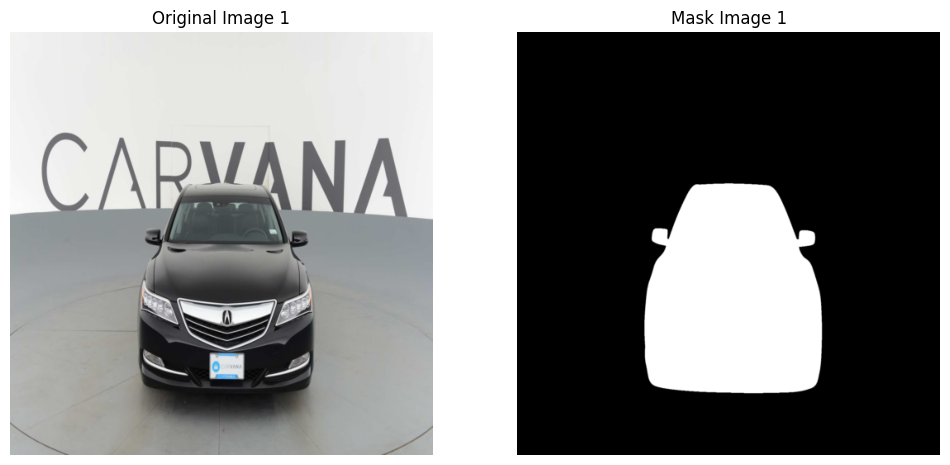

Batch 2:
Images shape: torch.Size([1, 3, 512, 512])
Masks shape: torch.Size([1, 1, 512, 512])


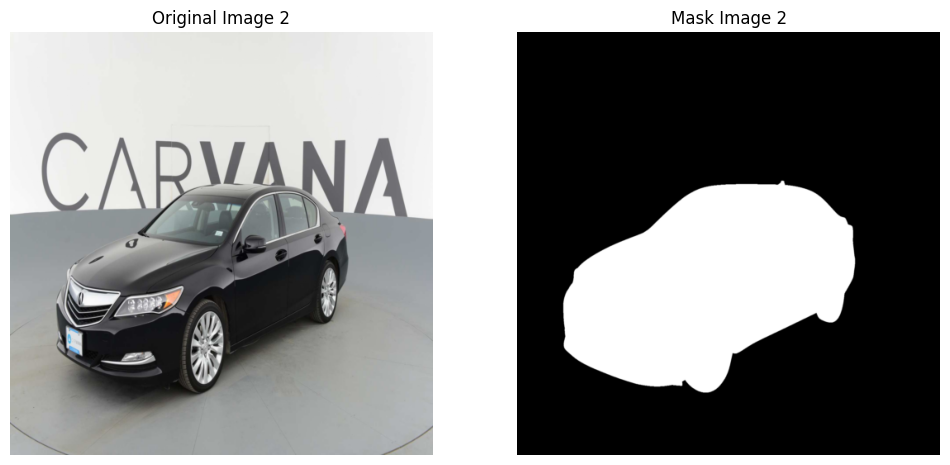

Batch 3:
Images shape: torch.Size([1, 3, 512, 512])
Masks shape: torch.Size([1, 1, 512, 512])


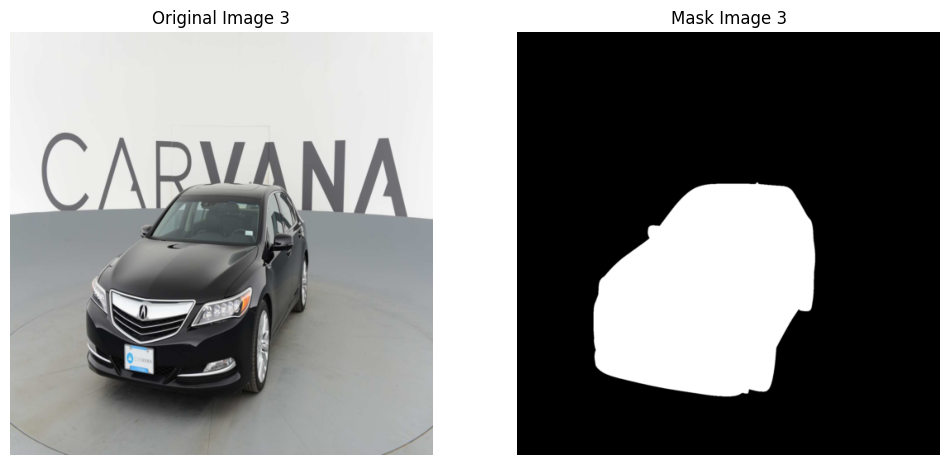

In [11]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Dataset instance
dataset = CarvanaDataset(root_path, limit=3)

# DataLoader instance
loader = DataLoader(dataset, batch_size=1, shuffle=True)


for i, (images, masks) in enumerate(loader):
    print(f"Batch {i+1}:")
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    plt.figure(figsize=(12,6))

    #Train Image
    plt.subplot(1, 2, 1)
    plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # Mask Image
    plt.subplot(1, 2, 2)
    plt.imshow(masks[0].squeeze(0).cpu().numpy(), cmap='gray')
    plt.title(f'Mask Image {i+1}')
    plt.axis('off')

    plt.show()



# Trainning the Model!!

In [12]:
train_dataset = CarvanaDataset(root_path)
generator = torch.Generator().manual_seed(25)

In [13]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator = generator)

In [14]:
test_dataset, val_dataset = random_split(test_dataset, [0.5,0.5], generator = generator)

**Running this experiment with CUDA**

In [15]:
num_workers = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
  num_workers = torch.cuda.device_count()*4

**Now We setup our model using the AdamW optimizer and the BCEWithLogitsLoss**

In [16]:
Learning_rate = 3e-4
batch_size = 8 # Reduced batch size to prevent OutOfMemoryError

train_dataloader = DataLoader(dataset = train_dataset, num_workers = num_workers, pin_memory = False, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, num_workers = num_workers, pin_memory = False, batch_size = batch_size, shuffle = False)
val_dataloader = DataLoader(dataset = val_dataset, num_workers = num_workers, pin_memory = False, batch_size = batch_size, shuffle = False)

# Initialize the UNet with num_classes=1 for binary segmentation and move it to the device
model = UNet(in_channels = 3, num_classes = 1).to(device)
optimizer = optim.AdamW(model.parameters(), lr = Learning_rate)
criterion = nn.BCEWithLogitsLoss()

**Evaluating Segmentation Performance with DICEMetric**

In [17]:
def dice_coefficient(prediction, target, epsilon=1e-07):
  prediction_copy = prediction.clone()

  prediction_copy[prediction_copy<0] = 0
  prediction_copy[prediction_copy>0] = 1

  intersection = abs(torch.sum(prediction_copy * target))
  union = abs(torch.sum(prediction_copy) + torch.sum(target))
  dice = (2.0 * intersection + epsilon) / (union + epsilon)

  return dice

In [18]:
torch.cuda.empty_cache()

**Training**

In [19]:
epochs = 10

train_losses = []
train_dcs = []

val_losses = []
val_dcs = []

for epoch in tqdm(range(epochs)):
  model.train()
  train_running_loss = 0
  train_running_dc = 0

  for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave = True)):
    img = img_mask[0].float().to(device)
    mask = img_mask[1].float().to(device)

    y_pred = model(img)
    optimizer.zero_grad()

    dc = dice_coefficient(y_pred, mask)
    loss = criterion(y_pred, mask)

    train_running_loss += loss.item()
    train_running_dc += dc.item()

    loss.backward()
    optimizer.step()



  train_loss = train_running_loss / (idx + 1)
  train_dc = train_running_dc / (idx + 1)

  train_losses.append(train_loss)
  train_dcs.append(train_dc)


  model.eval()
  val_running_loss = 0
  val_running_dc = 0

  with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave = True)):
      img = img_mask[0].float().to(device)
      mask = img_mask[1].float().to(device)

      y_pred = model(img)
      loss = criterion(y_pred , mask)
      dc = dice_coefficient(y_pred, mask)

      val_running_loss += loss.item()
      val_running_dc += dc.item()

    val_loss = val_running_loss / (idx + 1)
    val_dc = val_running_dc / (idx + 1)

  val_losses.append(val_loss)
  val_dcs.append(val_dc)


  print("-" * 30)
  print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
  print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
  print("\n")
  print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
  print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
  print("-" * 30)


 10%|█         | 1/10 [07:33<1:08:03, 453.67s/it]

------------------------------
Training Loss EPOCH 1: 0.1506
Training DICE EPOCH 1: 0.8196


Validation Loss EPOCH 1: 0.0310
Validation DICE EPOCH 1: 0.9707
------------------------------


 20%|██        | 2/10 [09:12<32:40, 245.03s/it]  

------------------------------
Training Loss EPOCH 2: 0.0405
Training DICE EPOCH 2: 0.9637


Validation Loss EPOCH 2: 0.0246
Validation DICE EPOCH 2: 0.9776
------------------------------


 30%|███       | 3/10 [10:51<20:48, 178.35s/it]

------------------------------
Training Loss EPOCH 3: 0.0178
Training DICE EPOCH 3: 0.9838


Validation Loss EPOCH 3: 0.0150
Validation DICE EPOCH 3: 0.9862
------------------------------


 40%|████      | 4/10 [12:30<14:42, 147.02s/it]

------------------------------
Training Loss EPOCH 4: 0.0128
Training DICE EPOCH 4: 0.9883


Validation Loss EPOCH 4: 0.0190
Validation DICE EPOCH 4: 0.9825
------------------------------


 50%|█████     | 5/10 [14:09<10:48, 129.69s/it]

------------------------------
Training Loss EPOCH 5: 0.0109
Training DICE EPOCH 5: 0.9899


Validation Loss EPOCH 5: 0.0095
Validation DICE EPOCH 5: 0.9910
------------------------------


 60%|██████    | 6/10 [15:48<07:56, 119.22s/it]

------------------------------
Training Loss EPOCH 6: 0.0256
Training DICE EPOCH 6: 0.9776


Validation Loss EPOCH 6: 0.0253
Validation DICE EPOCH 6: 0.9784
------------------------------


 70%|███████   | 7/10 [17:27<05:37, 112.61s/it]

------------------------------
Training Loss EPOCH 7: 0.0392
Training DICE EPOCH 7: 0.9631


Validation Loss EPOCH 7: 0.0488
Validation DICE EPOCH 7: 0.9558
------------------------------


 80%|████████  | 8/10 [19:06<03:36, 108.28s/it]

------------------------------
Training Loss EPOCH 8: 0.0240
Training DICE EPOCH 8: 0.9776


Validation Loss EPOCH 8: 0.0152
Validation DICE EPOCH 8: 0.9854
------------------------------


 90%|█████████ | 9/10 [20:45<01:45, 105.42s/it]

------------------------------
Training Loss EPOCH 9: 0.0138
Training DICE EPOCH 9: 0.9872


Validation Loss EPOCH 9: 0.0192
Validation DICE EPOCH 9: 0.9814
------------------------------


100%|██████████| 10/10 [22:24<00:00, 134.47s/it]


------------------------------
Training Loss EPOCH 10: 0.0116
Training DICE EPOCH 10: 0.9891


Validation Loss EPOCH 10: 0.0104
Validation DICE EPOCH 10: 0.9900
------------------------------


In [21]:
#Saving the model
torch.save(model.state_dict(), '/content/drive/MyDrive/UNet/Carvana_UNet_Model.pth')

# Results

**Traing and Validation**

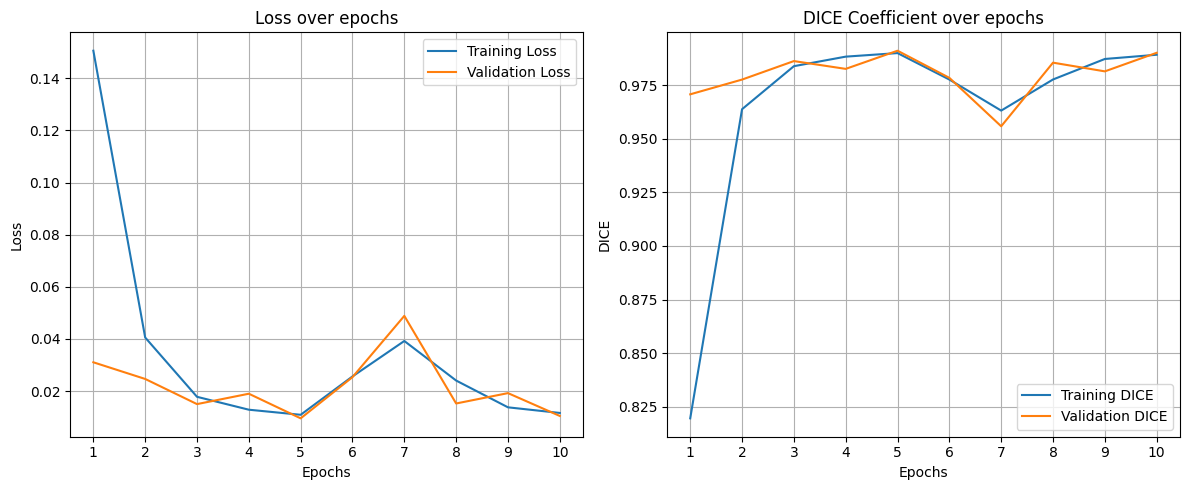

In [20]:
epochs_list = list(range(1, epochs + 1))

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, epochs+1, 1)))
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, epochs+1, 1)))
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.tight_layout()
plt.legend()

plt.show()

# Test

In [22]:
model_path = '/content/drive/MyDrive/UNet/Carvana_UNet_Model.pth'
trained_model = UNet(in_channels = 3, num_classes = 1).to(device)
trained_model.load_state_dict(torch.load(model_path, map_location = torch.device(device)))

<All keys matched successfully>

In [23]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
  for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave = True)):
    img = img_mask[0].float().to(device)
    mask = img_mask[1].float().to(device)

    y_pred = trained_model(img)
    loss = criterion(y_pred , mask)
    dc = dice_coefficient(y_pred, mask)

    test_running_loss += loss.item()
    test_running_dc += dc.item()

  test_loss = test_running_loss / (idx + 1)
  test_dc = test_running_dc / (idx + 1)

100%|██████████| 64/64 [00:41<00:00,  1.54it/s]


In [24]:
print(f'Test Loss: {test_loss:.4f}')
print(f'Test DICE: {test_dc:.4f}')

Test Loss: 0.0107
Test DICE: 0.9900
